Copyright **`(c)`** 2024 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# Set Cover problem

See: https://en.wikipedia.org/wiki/Set_cover_problem

In [506]:
from random import random, seed
import random
from itertools import accumulate
import numpy as np
from matplotlib import pyplot as plt

from icecream import ic

## Reproducible Initialization

If you want to get reproducible results, use `rng` (and restart the kernel); for non-reproducible ones, use `np.random`.

In [507]:
UNIVERSE_SIZE = 100000
NUM_SETS = 10000
DENSITY = 0.1

rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))

In [508]:
# DON'T EDIT THESE LINES!

SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        SETS[np.random.randint(NUM_SETS), s] = True
COSTS = np.power(SETS.sum(axis=1), 1.1)

## Helper Functions

In [509]:
def valid(solution, set):
    """Checks wether solution is valid (ie. covers all universe)"""
    return np.all(np.logical_or.reduce(set[solution]))


def cost(solution, cost_matrix):
    """Returns the cost of a solution (to be minimized)"""
    return cost_matrix[solution].sum()

## Have Fun!

In [510]:
# A dumb solution of "all" sets
solution = np.full(NUM_SETS, True)
valid(solution, SETS), cost(solution, COSTS)

(np.True_, np.float64(251229102.99266392))

In [511]:
# A random solution with random 50% of the sets
solution = rng.random(NUM_SETS) < .5
valid(solution, SETS), cost(solution, COSTS)

(np.True_, np.float64(124558327.0305906))

My Solution

In [512]:
def single_mutation(solution: np.ndarray, num_set) -> np.ndarray:
    new_sol = solution.copy()
    i = rng.integers(0, num_set)
    new_sol[i] = not new_sol[i]
    return new_sol

def multiple_mutation(solution: np.ndarray, num_set) -> np.ndarray:
    mask = rng.random(num_set) < 0.01
    new_sol = np.logical_xor(solution, mask)
    return new_sol

In [513]:
def fitness(solution: np.ndarray, set, cost_matrix):
    #I want to minimize the cost, but we have to consider also if the solution is valid.
    #We use a tuple.
    return (valid(solution, set), -cost(solution, cost_matrix))

Before applying hill climbing, I want to reduce the number of sets considered. We aim for sets with lower costs and high coverage of elements. Therefore, I consider the ratio between coverage and cost and select the best sets until all elements are covered.

In [514]:
min_sets = []
not_covered = np.ones(UNIVERSE_SIZE, dtype=bool)

while np.any(not_covered):
    best_set = None
    best_ratio = 0 
    for i in range(len(SETS)):
        if i in min_sets:
            continue
        # Calculate which elements this set would cover
        covered_by_set = np.where(SETS[i] & not_covered)[0]
        
        # If this set covers any new elements, calculate its value (coverage-to-cost ratio)
        if len(covered_by_set) > 0:
            coverage_to_cost_ratio = len(covered_by_set) / COSTS[i]  
            if coverage_to_cost_ratio > best_ratio:
                best_set = i
                best_ratio = coverage_to_cost_ratio
    
    # If we found a set to add, update the uncovered elements and solution
    if best_set is not None:
        min_sets.append(best_set)
        not_covered[np.where(SETS[best_set])[0]] = False  # Mark elements covered by the chosen set as covered

best_sets = SETS[min_sets]
best_set_indices = min_sets.copy()


Now I apply hill climbing, considering the fitness as valid and cost.

ic| fitness(solution, best_sets, cost_matrix): (np.True_, np.float64(-1526184.7450325314))
ic| fitness(solution, best_sets, cost_matrix): (np.True_, np.float64(-1526184.7450325314))


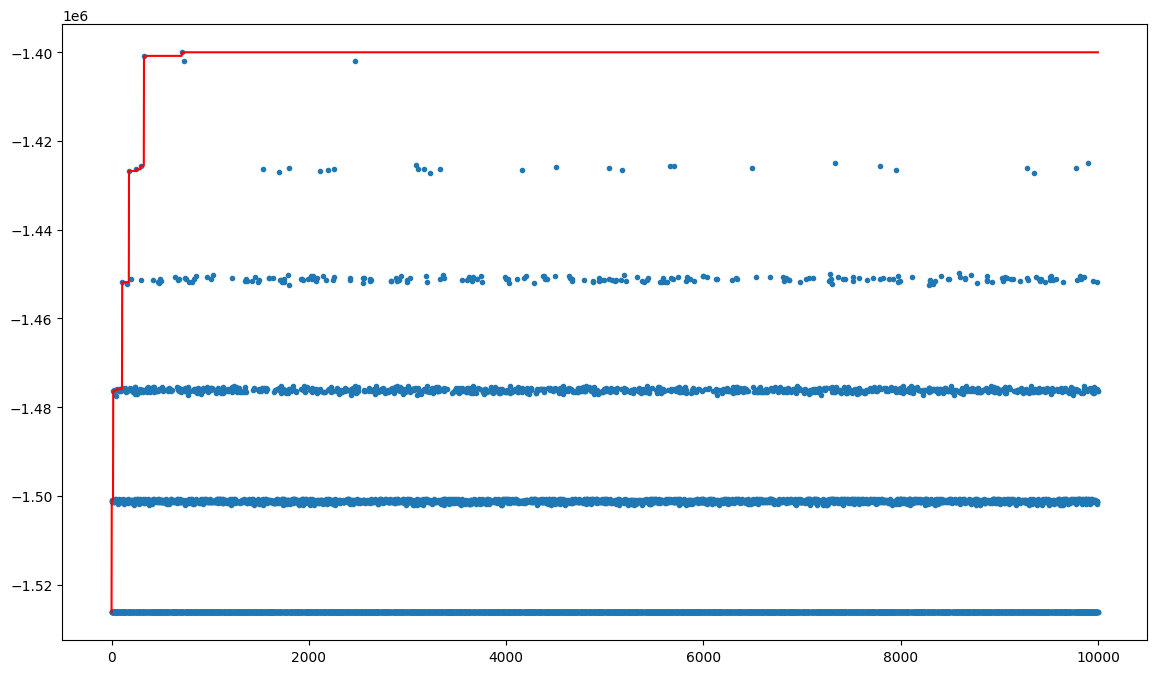

In [515]:
num_set = len(best_sets)
solution = rng.random(num_set) < 1
cost_matrix = COSTS[min_sets]
solution_fitness = fitness(solution,best_sets, cost_matrix )
history = [float(solution_fitness[1])] #plot of the cost
ic(fitness(solution, best_sets, cost_matrix))


for steps in range(10_000):
    
    new_solution = multiple_mutation(solution, num_set )
    f = fitness(new_solution, best_sets, cost_matrix)
    history.append(float(f[1]))
    
    if f > solution_fitness:
        solution = new_solution
        solution_fitness = fitness(solution, best_sets, cost_matrix)
        #ic(fitness(solution))
         
#ic(solution)
ic(fitness(solution, best_sets, cost_matrix))

plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),
    color="red",
)
_ = plt.scatter(range(len(history)), history, marker=".")


Another possible solution is to introduce slightly suboptimal sets to allow the hill climber to make better decisions.

In [516]:
min_sets = []
not_covered = np.ones(UNIVERSE_SIZE, dtype=bool)

while np.any(not_covered):
    best_set = None
    best_value = 0
    candidates = []

    for i in range(len(SETS)):
        if i in min_sets:
            continue
        covered_by_set = np.where(SETS[i] & not_covered)[0]
        if len(covered_by_set) > 0:
            coverage_to_cost_ratio = len(covered_by_set) / COSTS[i]
            candidates.append((i, coverage_to_cost_ratio))

    # Sort candidates by coverage-to-cost ratio
    candidates.sort(key=lambda x: x[1], reverse=True)
    
    # Select the best set, but with a chance to pick a slightly suboptimal one
    if candidates and random.random() < 0.7:  # 70% chance of picking the best one
        best_set = candidates[0][0]
    else:
        best_set = random.choice(candidates[:3])[0] #Pick one of the best 3 randomly

    if best_set is not None:
        min_sets.append(best_set)
        not_covered[np.where(SETS[best_set])[0]] = False
        
best_sets = SETS[min_sets]


ic| fitness(solution, best_sets, cost_matrix): (np.True_, np.float64(-1525740.101926722))
ic| fitness(solution, best_sets, cost_matrix): (np.True_, np.float64(-1525740.101926722))


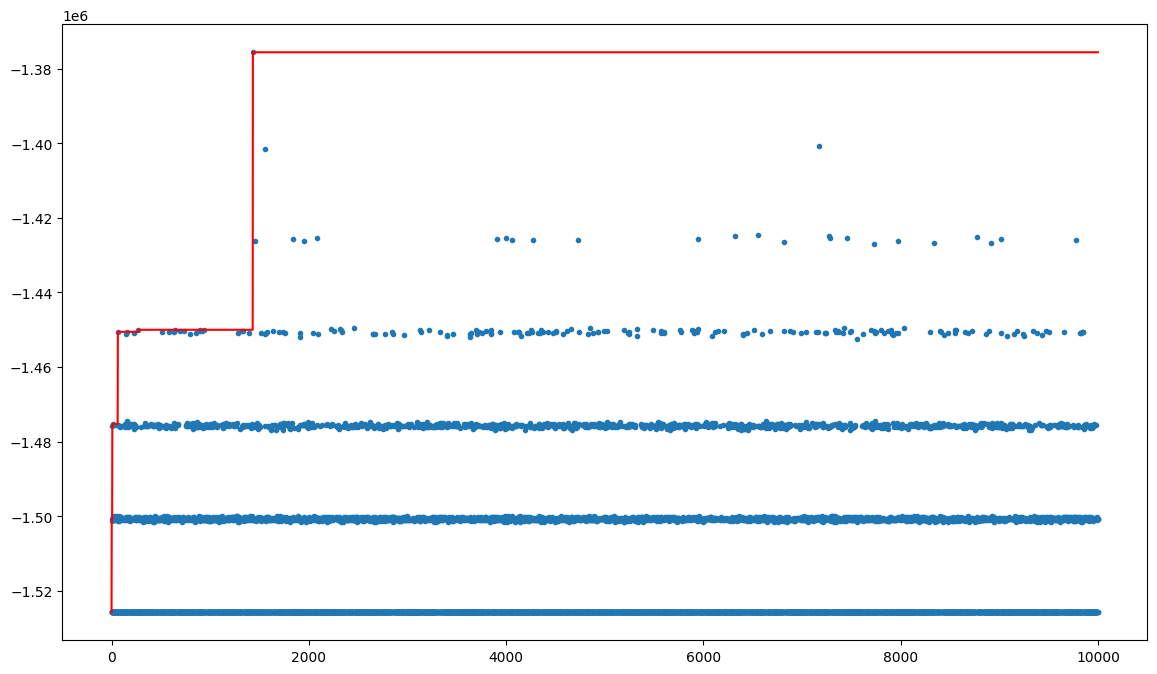

In [517]:
num_set = len(best_sets)
solution = rng.random(num_set) < 1
cost_matrix = COSTS[min_sets]
solution_fitness = fitness(solution,best_sets, cost_matrix )
history = [float(solution_fitness[1])] #plot of the cost
ic(fitness(solution, best_sets, cost_matrix))


for steps in range(10_000):
    
    new_solution = multiple_mutation(solution, num_set)
    f = fitness(new_solution, best_sets, cost_matrix)
    history.append(float(f[1]))
    
    if f > solution_fitness:
        solution = new_solution
        solution_fitness = fitness(solution, best_sets, cost_matrix)
        #ic(fitness(solution))
         
#ic(solution)
ic(fitness(solution, best_sets, cost_matrix))

plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),
    color="red",
)
_ = plt.scatter(range(len(history)), history, marker=".")
